In [7]:
from agent.agent import Agent
from agent.methods import get_state, evaluate_model, plot
import random
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import math
import os
from keras.models import load_model

dataset = pd.read_pickle(r'data\dqn3_1.pkl')
dataset = dataset[['sigmoid2_1','sigmoid2_2','sigmoid2_3','sigmoid2_4', 'sigmoid2_5','sigmoid2_6', 'sigmoid2_7','sigmoid2_8','sigmoid2_9','sigmoid2_10','Adj Open','Adj Close']]
train_data = dataset.loc['2018'].reset_index()
test_data = dataset.loc['2019'].reset_index()

state_size = len(train_data.columns) -3 +1 +2 #add one state hold, current profit rate, hold time,
state_size = (state_size,)
buffer_size = 40000

agent = Agent(buffer_size, state_size, )
# agent.load('test1_2000')

In [ ]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.995

data_length = train_data.index.max()
batch_size = 64

agent.n_iter = 1
agent.gamma = 0.95
agent.learning_rate =0.0001
history_train = {}
history_test = {}

for i in tqdm_notebook(range(2000)):
    train_profit = 0
    
    history_test[i]=[]
    history_train[i] = []
    inventory = []
    
    hold_day=0
    hold=0
    loss = 0
    reward_reserved = 0    
    state = get_state(train_data, 0, [hold, reward_reserved/(hold_day+1), hold_day*0.005])
    
    agent.first_iter = True
    agent.last_iter = False
    
    for t in range(1, data_length):
        
        reward = 0
        
        if (t == data_length - 1):
            agent.last_iter = True        

        # select an action
        action = agent.act(state, epsilon,)

        # BUY
        if (action == 0) and len(inventory) == 0:
            inventory.append(train_data['Adj Open'].loc[t])
            hold = 1
            history_train[i].append((1,t,reward))
        # SELL
        elif (action == 2) and len(inventory) > 0:
            bought_price = inventory.pop(0)
            delta = (train_data['Adj Open'].loc[t])/bought_price
            reward = np.log(delta-0.007)
            train_profit += reward
            hold = 0
            history_train[i].append((0,t,reward))

#       reward_reserved
        if hold == 1:
            hold_day += 1
            delta_reserved = (train_data['Adj Close'].loc[t])/inventory[0]
            reward_reserved = np.log(delta_reserved-0.007)
        else:
            hold_day = 0
            reward_reserved = 0        
        
        next_state = get_state(train_data, t , [hold, reward_reserved/(hold_day+1), hold_day*0.005])
        done = (t == data_length - 1)
        agent.remember_sumtree(state, action, reward, next_state, done) 

        agent.target_model_update(done, type='transfer')
        epsilon = agent.epsilon_decay(epsilon, epsilon_min, epsilon_decay)   
        agent.n_iter = agent.n_iter + 1

        if agent.buffer.buffer.total() // batch_size > 0 :
            loss = agent.train_experience_replay_sumtree(batch_size)         
        
        state = next_state
                
    test_profit, history_test[i] = evaluate_model(agent, train_data, history_test[i])
    
        
    print('turn:%0.0f  train:%0.4f  test:%0.4f' % (i, math.exp(train_profit), math.exp(test_profit)))



turn:0  train:0.8583  test:0.9473
turn:1  train:0.8274  test:0.9473
turn:2  train:0.8309  test:0.9473
turn:3  train:1.0162  test:0.9930
turn:4  train:0.9022  test:0.9473
turn:5  train:0.9289  test:0.9275
turn:6  train:0.9077  test:0.9473
turn:7  train:0.9473  test:0.9930
turn:8  train:0.9524  test:0.8869
turn:9  train:0.9308  test:0.9473
turn:10  train:0.9410  test:0.9635
turn:11  train:0.8512  test:0.9354
turn:12  train:0.8838  test:0.9571
turn:13  train:0.9689  test:1.0047
turn:14  train:0.8370  test:0.7570
turn:15  train:0.8625  test:0.9128
turn:16  train:0.8392  test:0.9891
turn:17  train:0.9023  test:0.8471
turn:18  train:0.8644  test:0.8651
turn:19  train:0.8530  test:1.0129
turn:20  train:0.8170  test:0.9295
turn:21  train:0.9264  test:0.7873
turn:22  train:0.9031  test:0.8798
turn:23  train:0.8911  test:0.9998
turn:24  train:0.8531  test:1.0004
turn:25  train:0.8578  test:0.9496
turn:26  train:0.8257  test:0.8087
turn:27  train:0.9591  test:0.8700
turn:28  train:0.7810  test:1.

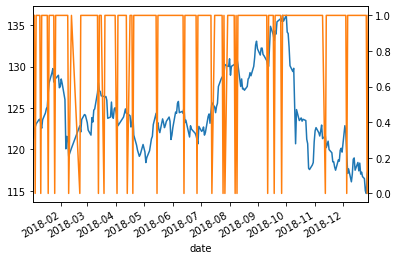

In [27]:
episode = 0
# result = plot(train_data, history_train[episode])
result.set_index('date')['Adj Close'].plot()
result.set_index('date')['sig'].plot(secondary_y=True)